# Plots for the Clustering Paper

This notebook contains all the plots made for the clustering paper.

In [ ]:
import spore

#from spore.mock.foregrounds import PointSourceForegrounds
#from spore.mock.utils import visibility_covariance
from spore.mock.convert_sim_to_vis import get_sim_21cmfast, sim_to_vis
from spore.mock.tocm_tools import readbox

from spore.model import source_counts, spatial_dist, spectral_index, beam, foregrounds
#from spore.model.foregrounds import PointSourceCircularGaussian, CircularGaussianPowerLaw
#from spore.model.source_counts import MultiPowerLawSourceCounts

from spore.visualise.power_spectra import plot_2D_PS, plot_2D_PS_compare, plot_2D_PS_ratio_diff, plot_2D_PS_frac_tot, plot_sig_to_noise_compare
from spore.measure import power_spectra_from_sim_direct as pssim, unit_conversions as uc
#from spore.measure.ps_2d_from_single_vis import power_spec_from_visibility

from astropy.cosmology import Planck15
from astropy import units as un
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np

import cPickle as pickle

from scipy.stats import norm
from scipy.special import i0,gamma,factorial,  hyp1f1
from scipy.integrate import simps
from scipy.signal import blackmanharris
from scipy.interpolate import InterpolatedUnivariateSpline as spline, griddata

from powerbox.tools import angular_average, get_power
from powerbox.dft import fft
from powerbox.powerbox import _magnitude_grid

import tqdm

from os.path import join

This notebook produced with ``spore`` version:

In [ ]:
spore.__version__

### Aesthetics

In [ ]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 13
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13


In [230]:
# Folder in which to save images (for paper)
figdir = "/home/steven/Desktop/"

## Source Count Model

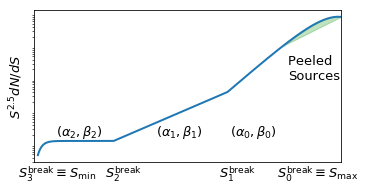

In [9]:
plt.figure(figsize=(5.5,2.8))
sc = spore.model.source_counts.MultiPowerLawSourceCounts(Smax0=1.,Smin0=1e-8,alpha=4100,beta=[1.5,2.,2.5],Sbreak=[1e-3,1e-6])
s = np.logspace(-8,0,1000)[:-1]
dn = sc.dnds(s)
dn *= np.exp(-(1e-8/s)**4)
dn *= np.exp(-(2*s)**0.7)

dn *= s**2.5
plt.plot(s, dn)
plt.xscale('log')
plt.yscale('log')

plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off',labelleft='off', labeltop='off', labelright='off', labelbottom='off')

plt.vlines([1e-6,1e-3],[0,0],[sc.dnds(1e-6)*1e-15,sc.dnds(1e-3)*10**-7.5])
plt.fill_between(s[s>=3e-2], dn[s>=3e-2],color='C2',alpha=0.3)

plt.text(4e-2,1e1,"Peeled \nSources")
plt.text(2e-2,1.e-2,r"$S^{\rm break}_0 \equiv S_{\rm max}$")
plt.text(0.6e-3,1.e-2, r"$S^{\rm break}_1$")
plt.text(0.6e-6,1.e-2, r"$S^{\rm break}_2$")
plt.text(0.3e-8,1.e-2,r"$S^{\rm break}_3 \equiv S_{\rm min}$")

plt.text(1.2e-3,2e-1,r"$(\alpha_0,\beta_0)$")
plt.text(1.3e-5,2e-1,r"$(\alpha_1,\beta_1)$")
plt.text(3e-8,2e-1,r"$(\alpha_2,\beta_2)$")

#plt.xlabel("$\log S$ [Arbitrary Units]")
plt.ylabel("$S^{2.5} dN/dS$")

plt.xlim(0.8e-8,1)

if figdir:
    plt.savefig(join(figdir,"source_count_schematic.pdf"))

## Testing Separability of Poisson/Clustering

In [7]:
u0 = 0.02
kappa = 1.5

nu1 = 1.25
nu2 = 1.5

sc_pl_test = source_counts.PowerLawSourceCounts(f0=[1.,nu1,nu2],Smax0=1e0,Smin0=1e-1,alpha=6998.,beta=1.54)
sid_univ = spectral_index.UniversalDist(0.8)
beam_test = beam.CircularGaussian(150., f0=[1.,nu1,nu2])

spat_dist_poiss = spatial_dist.PoissonClustering_FlatSky(f0=[1.,nu1,nu2], sky_size=8*beam_test.sigma,
                                                         ncells=256)
spat_dist_poiss_clust = spatial_dist.PoissonClustering_FlatSky(f0=[1.,nu1,nu2], sky_size=8*beam_test.sigma,
                                                               ncells=256, 
                                                               power_spectrum = lambda u : (u/u0)**-kappa)
spat_dist_clust = spatial_dist.PureClustering_FlatSky(f0=[1.,nu1,nu2], sky_size=8*beam_test.sigma,
                                                      ncells=256,
                                                      power_spectrum = lambda u : (u/u0)**-kappa)


cf = PointSourceForegrounds(source_counts = sc_pl_test,
                            beam_model = beam_test,
                            spec_index_model = sid_univ,
                            spatial_dist = spat_dist_poiss_clust)

cof = PointSourceForegrounds(source_counts = sc_pl_test,
                             beam_model = beam_test,
                             spec_index_model = sid_univ,
                             spatial_dist = spat_dist_clust)

pf = PointSourceForegrounds(source_counts = sc_pl_test,
                             beam_model = beam_test,
                             spec_index_model = sid_univ,
                             spatial_dist = spat_dist_poiss)


model = foregrounds.CircularGaussianPowerLaw(source_counts=cf.source_counts,
                                  beam_model=cf.beam_model,
                                  u =np.logspace(0,1.8,50),
                                  clustering_params={"u0":u0,"kappa":kappa})


ubins, vis_covar_cf = visibility_covariance(foreground_model=cf.__class__,
                                         niter=200, seed=1234,
                                         source_counts = sc_pl_test,
                                         beam_model = beam_test,
                                         spec_index_model = sid_univ,
                                         spatial_dist = cf.spatial_dist)

ubins, vis_covar_cof = visibility_covariance(foreground_model=cof.__class__,
                                         niter=200, seed=1234,
                                         source_counts = sc_pl_test,
                                         beam_model = beam_test,
                                         spec_index_model = sid_univ,
                                         spatial_dist = cof.spatial_dist)

ubins, vis_covar_pf = visibility_covariance(foreground_model=pf.__class__,
                                         niter=200, seed=1234,
                                         source_counts = sc_pl_test,
                                         beam_model = beam_test,
                                         spec_index_model = sid_univ,
                                         spatial_dist = pf.spatial_dist)

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/mock/ps_foregrounds.py:146: ComplexWarning: Casting complex values to real discards the imaginary part
  vis2[i,j+i] = self._circavg(v2)
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/mock/ps_foregrounds.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  vis2[j+i,i] = self._circavg(v2)
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in power


In [42]:
import pickle

try:
    vis_covar
    with open("all_my_data_u.pkl",'w') as f:
        pickle.dump({"ubins":ubins,"vis_covar":vis_covar,"vis_covar_only":vis_covar_only,"vis_covar_pf":vis_covar_pf},f)

except NameError:
    with open("all_my_data_u.pkl",'r') as f:
        d = pickle.load(f)
        ubins = d['ubins']
        vis_covar = d['vis_covar']
        vis_covar_only = d['vis_covar_only']
        vis_covar_pf = d['vis_covar_pf']
 

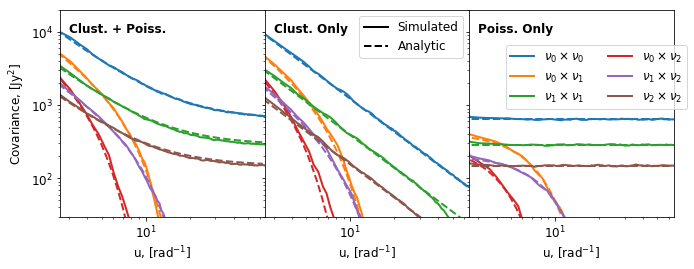

In [10]:
fig, ax = plt.subplots(1,3, figsize=(11,3.8),sharex=True,sharey=True,
                       gridspec_kw={"hspace":0,'wspace':0},
                       subplot_kw={"xscale":"log","yscale":'log',"ylim":(30,2e4),"xlim":(2.6,65)})

mpl.rcParams['font.size'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# Generate legend entries
ax[1].plot([0],[0],color="k",label="Simulated")
ax[1].plot([0],[0],color="k",ls='--',label="Analytic")

for i,(vistype, modtype) in enumerate(zip([vis_covar_cf, vis_covar_cof, vis_covar_pf],
                                          [model.total_covariance, model.clustered_only_covariance, model.poisson_covariance])):
    ii = 0
    for jj in range(3):
        for kk in range(jj+1):
            if i == 2:
                label = r"$\nu_%s \times \nu_%s$"%(kk,jj)
            else:
                label = None
                
            ax[i].plot(ubins, vistype[kk,jj], color="C%s"%ii, label=label)
            ax[i].plot(model.u, modtype[:,kk,jj], color="C%s"%ii, ls='--')
            
            ii +=1

ax[0].set_xlabel(r"u, [${\rm rad}^{-1}$]")
ax[1].set_xlabel(r"u, [${\rm rad}^{-1}$]")
ax[2].set_xlabel(r"u, [${\rm rad}^{-1}$]")
ax[0].set_ylabel(r"Covariance, [${\rm Jy}^2$]")

ax[0].text(3,10000,"Clust. + Poiss.", fontweight="bold")
ax[1].text(3,10000,"Clust. Only",fontweight='bold')
ax[2].text(3,10000,"Poiss. Only",fontweight='bold')

ax[1].legend()
ax[2].legend(ncol=2,bbox_to_anchor=(0.68, 0.495),
           bbox_transform=plt.gcf().transFigure)

if figdir:
    fig.savefig(join(figdir,"compare_clustering_only.pdf"))

Covariance between frequency channels of visibilities including only point sources. Only two frequency channels are shown for clarity, and these are exaggerated. The reference frequency ``$\nu_0$`` = {{model.beam_model.nu0}}Mhz, and the displayed frequencies are ``$f_0 = (``{{model.nu[0]}},{{model.nu[1]}}, {{model.nu[2]}}``)$``. The box-size of the simulation is four times the FWHM of the beam, at {{"%1.2f"%cf.sky_size[0]}}, with {{cf.ncells}} grid cells per side, and 200 realisations were used in order to generate the covariance. The power-law power spectrum has ``$(\omega_0,\kappa)=({{u0}},{{kappa}})$``. Blue, green and brown lines indicate variances at each frequency as a function of the perpendicular scale ``$u$``, while the orange, purple and maroon lines indicate covariances between the frequencies. Solid lines show fully simulated results, while dashed lines show the result of Eq. ``\ref{eq:general_clustering_covariance}``. The LHS panel shows the results of the full covariance, with both clustering and Poisson scatter present, while the centre and RHS panels show the results with just clustering and Poisson terms respectively. Eq. ``\ref{eq:general_clustering_covariance}`` assumes these stochastic effects can be separated, and the LHS panel confirms the validity of this assumption, revealing no significant departure of the simulation from the model. The primary effect of including Poisson scatter is to add a constant to the variances, to which the solutions asymptote.

## Simple Comparison of Power Spectra

[ 0.044039    0.04390063  0.0437629   0.04362582  0.04348938  0.04335358
  0.04321842  0.04308389  0.04294998  0.0428167   0.04268404  0.04255199
  0.04242056  0.04228973  0.04215951  0.04202989  0.04190086  0.04177243
  0.04164459  0.04151733  0.04139066  0.04126456  0.04113904  0.0410141
  0.04088972  0.0407659   0.04064265  0.04051996  0.04039782  0.04027623
  0.04015519  0.04003469  0.03991474  0.03979532  0.03967644  0.03955809
  0.03944027  0.03932298  0.03920621  0.03908995  0.03897422  0.03885899
  0.03874428  0.03863007  0.03851637  0.03840317  0.03829047  0.03817826
  0.03806655  0.03795533  0.03784459  0.03773434  0.03762456  0.03751527
  0.03740645  0.0372981   0.03719023  0.03708282  0.03697588  0.03686939
  0.03676337  0.03665781  0.03655269  0.03644803  0.03634382  0.03624006
  0.03613673  0.03603385  0.03593141  0.03582941  0.03572784  0.03562669
  0.03552598  0.0354257   0.03532584  0.0352264   0.03512738  0.03502877
  0.03493059  0.03483281  0.03473544  0.03463849  0.

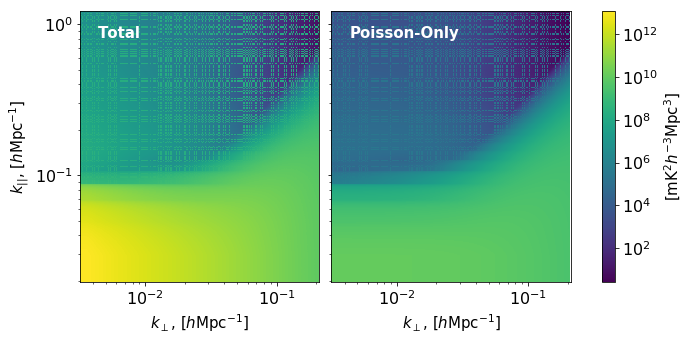

In [6]:
u0 = 0.05
kappa = 1.5

mpl.rcParams['font.size'] = 15
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

f0 = np.linspace(1,180./150.,128)

model = foregrounds.CircularGaussianPowerLaw(source_counts=source_counts.MultiPowerLawSourceCounts(f0=f0,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                             beam_model=beam.CircularGaussian(nu0=150.),
                                             u =np.linspace(3,200.0,300),
                                             clustering_params={"u0":u0,"kappa":kappa})

total_ps = model.power_cov_total(taper=blackmanharris)
poiss_ps = model.power_cov_poisson(taper=blackmanharris)
plot_2D_PS_compare([[np.sqrt(total_ps)],[np.sqrt(poiss_ps)]],model.kperp,model.kpar,interp="bilinear", plt_labels=[['Total'], ["Poisson-Only"]])

if figdir:
    plt.savefig(join(figdir,"compare_total_poisson_PS.pdf"))
    
plt.show()

## Ratios for different parameter choices

In [8]:
# BASIC PARAMETERS
f0 = np.linspace(1,180./150.,128)

fiducial_sc = source_counts.MultiPowerLawSourceCounts(f0=f0,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006])
fiducial_beam = beam.CircularGaussian(nu0=50.)
fiducial_clst = {"u0":0.05,"kappa":1.5}
u = np.linspace(3,200.,300)

# CREATE MODELS
model = foregrounds.CircularGaussianPowerLaw(source_counts=fiducial_sc, 
                                 beam_model=fiducial_beam,
                                 u=u,
                                 clustering_params=fiducial_clst)
model_slope = foregrounds.CircularGaussianPowerLaw(source_counts=fiducial_sc, 
                                 beam_model=fiducial_beam,
                                 u =u,
                                 clustering_params={"u0":0.05,"kappa":2.5})
model_u0 = foregrounds.CircularGaussianPowerLaw(source_counts=fiducial_sc, 
                                 beam_model=fiducial_beam,
                                 u =u,
                                 clustering_params={"u0":0.1,"kappa":1.5})
model_Smax = foregrounds.CircularGaussianPowerLaw(source_counts=source_counts.MultiPowerLawSourceCounts(f0=f0,Smax0=0.001,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=fiducial_beam,
                                 u =u,
                                 clustering_params=fiducial_clst)
model_Smin = foregrounds.CircularGaussianPowerLaw(source_counts=source_counts.MultiPowerLawSourceCounts(f0=f0,Smax0=0.03,Smin0=1e-6,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=fiducial_beam,
                                 u =u,
                                 clustering_params=fiducial_clst)
model_beta = foregrounds.CircularGaussianPowerLaw(source_counts=source_counts.MultiPowerLawSourceCounts(f0=f0,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,2.2],Sbreak=[0.006]), 
                                 beam_model=fiducial_beam,
                                 u =u,
                                 clustering_params=fiducial_clst)

# # GET P,K VALUES
PS = {}
PS_b = {}
for name,mod in zip(["fid",'slope','u0','Smax',"Smin",'beta'],[model,model_slope,model_u0,model_Smax,model_Smin,model_beta]):
    PS_t = mod.power_cov_total(taper=None).value
    PS_p = mod.power_cov_poisson(taper=None).value
    PS[name] = np.sqrt(PS_t/PS_p)
    PS_b[name] = np.sqrt((PS_p)/PS_t)
    KPAR = mod.kpar.value
    KPERP = mod.kperp.value

[ 0.39635103  0.39510563  0.39386608  0.39263236  0.39140442  0.39018224
  0.38896577  0.38775498  0.38654984  0.38535031  0.38415635  0.38296793
  0.38178502  0.38060758  0.37943558  0.37826898  0.37710776  0.37595187
  0.3748013   0.37365599  0.37251593  0.37138107  0.3702514   0.36912687
  0.36800746  0.36689313  0.36578385  0.3646796   0.36358034  0.36248604
  0.36139668  0.36031222  0.35923263  0.35815789  0.35708796  0.35602282
  0.35496244  0.35390679  0.35285585  0.35180957  0.35076795  0.34973094
  0.34869852  0.34767067  0.34664736  0.34562856  0.34461424  0.34360438
  0.34259896  0.34159794  0.3406013   0.33960902  0.33862107  0.33763742
  0.33665805  0.33568294  0.33471205  0.33374538  0.33278288  0.33182454
  0.33087034  0.32992025  0.32897424  0.32803229  0.32709439  0.3261605
  0.32523061  0.32430468  0.32338271  0.32246466  0.32155052  0.32064025
  0.31973385  0.31883129  0.31793254  0.31703758  0.3161464   0.31525897
  0.31437528  0.31349529  0.31261899  0.31174637  0.

1 / sr sr


In [9]:
# DO PLOT
def make_ratio_plot(PS,lognorm=True,cl='white'):
    fig, ax = plt.subplots(2, 3, figsize=(9,5), sharex=True, sharey=True,
                           subplot_kw={"xscale": 'log', "yscale": 'log'},gridspec_kw={"hspace":0.05,"wspace":0.05})

    if lognorm:
        norm = LogNorm(vmin=np.min([v for v in PS.values()]), vmax=np.max([v for v in PS.values()]))
        vmin=vmax=None
    else:
        norm = None
        vmin=np.min([v for v in PS.values()])
        vmax=np.max([v for v in PS.values()])
        
    interp = "bilinear"

    cax1 = ax[0,0].imshow(PS['fid'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax2 = ax[0,1].imshow(PS['slope'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax3 = ax[0,2].imshow(PS['u0'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax4 = ax[1,0].imshow(PS["Smax"], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax5 = ax[1,1].imshow(PS['Smin'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax6 = ax[1,2].imshow(PS["beta"], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)

    cbar = fig.colorbar(cax1, ax=ax.ravel().tolist())

    ax[0,0].text(0.5, 0.85, "Fiducial", transform=ax[0,0].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha='center')
    ax[0,1].text(0.5, 0.85, "$\kappa = 2.5$", transform=ax[0,1].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[0,2].text(0.5, 0.85, "$u_0 = 0.1$", transform=ax[0,2].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[1,0].text(0.5, 0.85, r"$S_{\rm max} = 1$ mJy", transform=ax[1,0].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[1,1].text(0.5, 0.85, r"$S_{\rm min} = 10^{-3}$ mJy", transform=ax[1,1].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[1,2].text(0.5, 0.85, r"$\beta_1 = 2.2$", transform=ax[1,2].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")

    cbar.ax.set_ylabel("Poisson Cov. Fraction", fontsize=13)

    ax[1,1].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
    ax[1,0].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
    ax[1,2].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)

    ax[0,0].set_ylabel(r"$k_{||}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
    ax[1,0].set_ylabel(r"$k_{||}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)

    return fig


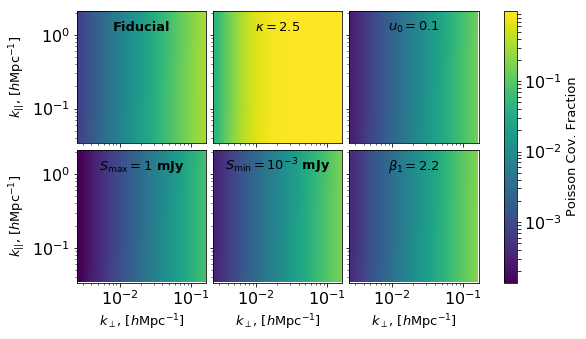

In [10]:
fig = make_ratio_plot(PS_b,True,cl='k')

if figdir:
    fig.savefig(join(figdir,"compare_ratios_bias_PS.pdf"))
    
plt.show()

## Connect To Instruments

### Get Power Spectrum from Basic Box

In [112]:
pk_2d, kperp, kpar, simdat = pssim.get_power_lightcone("/home/steven/Documents/Projects/Foregrounds/DataSets/delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel", 
                                               get_delta=False, res_ndim=2, taper=blackmanharris)

pk_1d, kav_1d = pssim.get_power_lightcone("/home/steven/Documents/Projects/Foregrounds/DataSets/delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel", taper=blackmanharris)

simf0 = np.linspace(1,simdat['nu'].max()/simdat['nu'].min(),len(simdat['nu']))
sim_u = Planck15.h*Planck15.comoving_distance(simdat['z'].min()) * kperp/(2*np.pi)

{'dim': 1024, 'BoxSize': 1600, 'basedir': '/home/steven/Documents/Projects/Foregrounds/DataSets', 'HIIdim': 1024, 'filename': 'delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel', 'z': 0.0, 'type': 'deltaT'}
[ 5.          5.00446531  5.00893062 ...,  9.55907938  9.56354469  9.56801   ] [ 7955.26716772  7957.67083891  7960.07185629 ...,  9550.11164822
  9551.14519859  9552.17809448] Mpc
{'dim': 1024, 'BoxSize': 1600, 'basedir': '/home/steven/Documents/Projects/Foregrounds/DataSets', 'HIIdim': 1024, 'filename': 'delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel', 'z': 0.0, 'type': 'deltaT'}
[ 5.          5.00446531  5.00893062 ...,  9.55907938  9.56354469  9.56801   ] [ 7955.26716772  7957.67083891  7960.07185629 ...,  9550.11164822
  9551.14519859  9552.17809448] Mpc


Plot the 2D power spectrum of the raw EoR simulation, to get a feel for where the power really is:

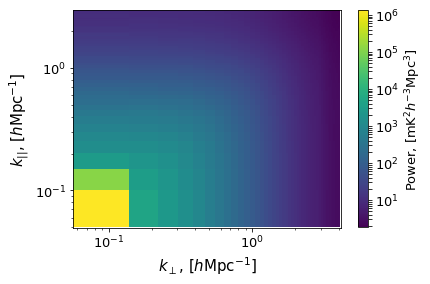

In [113]:
fig, ax = plot_2D_PS(pk_2d.T,kperp,kpar)

In [121]:
# Get all bins close to k = 6e-1
KPERP, KPAR = np.meshgrid(kperp, kpar)
K = np.sqrt(KPERP**2 + KPAR**2)
kbins_tmp = np.linspace(K.min(), K.max()*1.001, 21)
mask = np.logical_and(K>kbins_tmp[1], K<kbins_tmp[2])

In [165]:
kpar_ = KPAR[mask].flatten()
cov_t = hu_pc['ska_t'][mask].flatten().value
cov_p = hu_pc['ska_p'][mask].flatten().value
p = np.abs(hu_total_power['ska'][mask]).flatten().value
s = pk_2d.T[mask].flatten()
kk = K[mask].flatten()

(1e-11, 0.01)

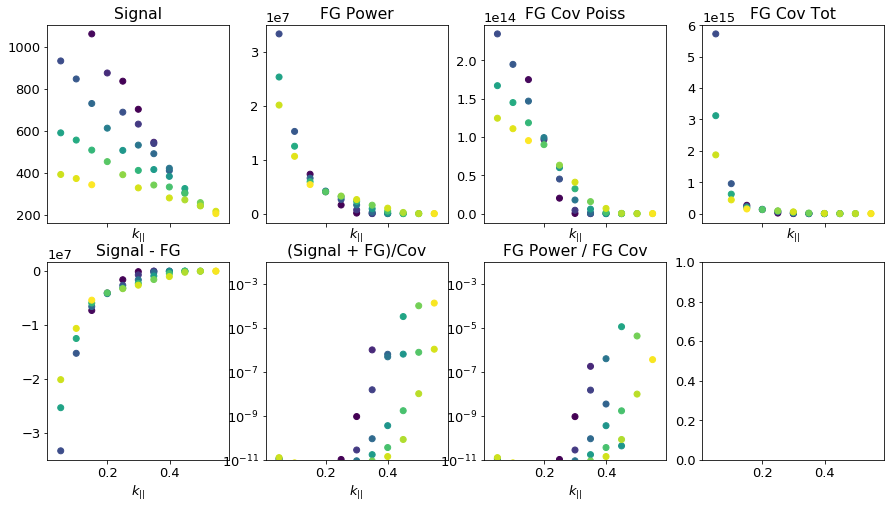

In [166]:
fig, ax = plt.subplots(2,4, figsize=(15,8), sharex=True)
ax[0,0].scatter(kpar_, s, c=kk)
ax[0,0].set_xlabel(r"$k_{||}$")
ax[0,0].set_title("Signal")

ax[0,1].scatter(kpar_, p, c=kk)
ax[0,1].set_xlabel(r"$k_{||}$")
ax[0,1].set_title("FG Power")

ax[0,2].scatter(kpar_, cov_p, c=kk)
ax[0,2].set_xlabel(r"$k_{||}$")
ax[0,2].set_title("FG Cov Poiss")


ax[0,3].scatter(kpar_, cov_t, c=kk)
ax[0,3].set_xlabel(r"$k_{||}$")
ax[0,3].set_title("FG Cov Tot")

ax[1,2].scatter(kpar_, p/cov, c=kk)
ax[1,2].set_xlabel(r"$k_{||}$")
ax[1,2].set_title("FG Power / FG Cov")
ax[1,2].set_yscale('log')
ax[1,2].set_ylim(1e-11,1e-2)

ax[1,0].scatter(kpar_, s -p, c=kk)
ax[1,0].set_xlabel(r"$k_{||}$")
ax[1,0].set_title("Signal - FG")

ax[1,1].scatter(kpar_, (s +p)/cov, c=kk)
ax[1,1].set_xlabel(r"$k_{||}$")
ax[1,1].set_title("(Signal + FG)/Cov")
ax[1,1].set_yscale('log')
ax[1,1].set_ylim(1e-11,1e-2)

#ax[0].colorbar()

In [167]:
print "Noiseless: ", 1/np.sum(1/cov_t) * np.sum((s)/cov_t)
print "True Est.: ", 1/np.sum(1/cov_t) * np.sum((s + p)/cov_t)
print "Poiss Est.", 1/np.sum(1/cov_p) * np.sum((s + p)/cov_p)

Noiseless:  287.350393505
True Est.:  976.314469045
Poiss Est. 251.69317412


In [169]:
print np.sum((s + p)/cov_t)/ np.sum((s + p)/cov_p)
print np.sum(1/cov_p)/ np.sum(1/cov_t)

0.000144565356088
26832.0625477


In [162]:
smask = p > 100*s

In [163]:
(cov_t/cov_p)[smask]

array([  31.09538773,   19.31570089,   13.29524765,   31.09597072,
         19.3159526 ,   13.29537104,   58.45557851,   31.09694482,
         19.31637261,   13.29557682,   58.45933642,   31.09831365,
         19.31696164,  141.95252341,   58.46422694,   31.1000822 ,
         19.3177207 ,  563.3005637 ,  141.97278384,   58.47028924,
         31.10225671,   19.31865106,  560.79062932,  141.99654491,
         58.47756495,   31.10484458,  546.86591875,  142.0220942 ,
         58.48609357,   31.10785415,  499.03688249,  142.04519448,
         58.49590588,  142.05635936])

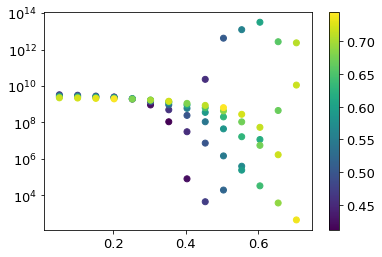

In [52]:
plt.scatter(KPAR[mask].flatten(), fid_pc['mwa_p'][mask].flatten().value/np.abs(total_power['mwa'])[mask].flatten().value,
            c=K[mask].flatten())
plt.colorbar()
plt.yscale('log')

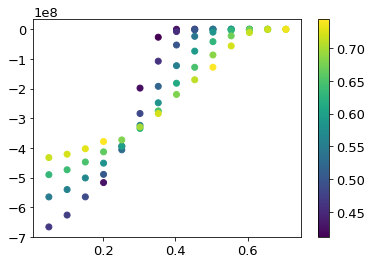

In [50]:
plt.scatter(KPAR[mask].flatten(), pk_2d.T[mask].flatten() - np.abs(total_power['mwa'])[mask].flatten().value, c=K[mask].flatten())
plt.colorbar()

In [8]:
# 1D PS from 2D
kcoords = np.sqrt(np.add.outer(kperp**2, kpar**2)).T
mean_signal_true, kbins_true = angular_average(pk_2d.T, kcoords, bins=50)

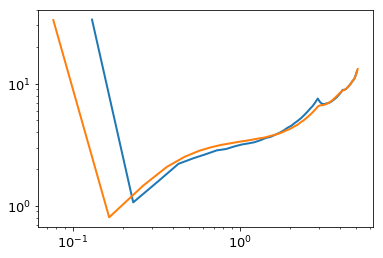

In [9]:
# Just to make sure we're averaging down correctly
plt.plot(kbins_true,mean_signal_true * kbins_true**3/(2*np.pi**2))
plt.plot(kav_1d,pk_1d)
plt.xscale('log')
plt.yscale('log')

### Covariance Model For Each Instrument

In [233]:


def average_to_1d(kperp,kpar,power, power_cov,bins=15):
    # Average to 1D
    kcoords = np.sqrt(np.add.outer(kperp**2, kpar**2)).T
    weights = 1./power_cov

    mean_true_signal, kbins = angular_average(pk_2d.T.copy() , kcoords, bins=bins, weights = weights.value)
    mean_signal, kbins = angular_average(pk_2d.T.copy() + power.value, kcoords, bins=bins, weights = weights.value)
    
    variance = 1/angular_average(1./power_cov, kcoords, bins=bins)[0]
    return kbins, mean_signal, variance, mean_true_signal
    
def make_models(Smin,beta1,u0,kappa, f0,u):
    
    def get_ps_and_cov(sc,D):
        ps_model = foregrounds.CircularGaussianPowerLaw(
            source_counts=sc, 
            beam_model=beam.CircularGaussian(nu0=150., D=D),
            u =u.value,
            clustering_params={"u0":u0 ,"kappa":kappa}
        )

        # Galactic (we just hack this for the time being)
        gal_model = foregrounds.CircularGaussianPowerLaw(
            source_counts = source_counts.PowerLawSourceCounts(
                f0=f0, Smin0=1, Smax0=4,beta = 1.5, 
                alpha= 0.13 /2,
                spectral_index = 0.55
            ),
            beam_model = beam.CircularGaussian(nu0=150.0),
            u = u.value,
            clustering_params = {"u0":0.105, "kappa":2.7},
        )
        
        total_cov = ps_model.power_cov_total(blackmanharris) + gal_model.power_cov_total(blackmanharris)
        poiss_cov = ps_model.power_cov_poisson(blackmanharris) + gal_model.power_cov_total(blackmanharris)
        total_power = np.abs(ps_model.power_total(blackmanharris)) + np.abs(gal_model.power_total(blackmanharris)) #np.sqrt(total_cov) #

        return total_cov, poiss_cov, total_power, ps_model.kperp, ps_model.kpar, ps_model
    
    total_cov_mwa, poiss_cov_mwa, total_power_mwa, mwa_kperp, mwa_kpar, model_mwa = get_ps_and_cov(
        sc = source_counts.MultiPowerLawSourceCounts(
            f0=f0,Smax0=3e-2,Smin0=Smin,alpha=6998.,beta=[1.54,beta1],Sbreak=[0.006]
        ), 
        D=4.
    )
    
    total_cov_ska, poiss_cov_ska, total_power_ska, ska_kperp, ska_kpar, model_ska = get_ps_and_cov(
        sc = source_counts.PowerLawSourceCounts(
            f0=f0,Smax0=1e-3,Smin0=Smin,alpha=237.9,beta=beta1
        ), 
        D=35.
    )
    
    k_1d, sig_full_mwa, var_tot_mwa, sig_true_mwa = average_to_1d(
        mwa_kperp.value, mwa_kpar.value, np.abs(total_power_mwa), total_cov_mwa, bins=15)
    k_1d, sig_poiss_mwa, var_poiss_mwa, _ = average_to_1d(
        mwa_kperp.value, mwa_kpar.value, np.abs(total_power_mwa), poiss_cov_mwa, bins=15)
 
    k_1d, sig_full_ska, var_tot_ska, sig_true_ska = average_to_1d(
        ska_kperp.value, ska_kpar.value, np.abs(total_power_ska), total_cov_ska, bins=15)
    k_1d, sig_poiss_ska, var_poiss_ska, _ = average_to_1d(
        ska_kperp.value, ska_kpar.value, np.abs(total_power_ska), poiss_cov_ska, bins=15)
        
    
    return ({"mwa_t":total_cov_mwa, "mwa_p":poiss_cov_mwa, "ska_t":total_cov_ska, "ska_p":poiss_cov_ska}, 
            {"mwa":model_mwa, "ska":model_ska}, k_1d,
            {"mwa_t":sig_full_mwa, "mwa_p":sig_poiss_mwa, "ska_t":sig_full_ska, "ska_p":sig_poiss_ska},
            {"mwa_t":var_tot_mwa, "mwa_p":var_poiss_mwa,"ska_t":var_tot_ska,"ska_p":var_poiss_ska},
            {"ska":total_power_ska, "mwa":total_power_mwa, "ska_true":sig_true_ska, "mwa_true":sig_true_mwa},
            {"mwa_kpar":mwa_kpar, "mwa_kperp":mwa_kperp})
    

def make_1d_plot_ax(total_power, k_1d, signal, variance, fig=None,ax=None, plt_labels=True):
    if fig is None and ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,5))
        
    
    k = k_1d[1:]
    fac = k**3/(2*np.pi**2)
    
    ax.plot(k,total_power['mwa_true'][1:]*fac,label="Noise-Free Model (MWA)")
    ax.plot(k,total_power['ska_true'][1:]*fac,label="Noise-Free Model (SKA)")
    
    
    def get_plot_data(kind, offset=1):
        sig = signal[kind][1:] * fac
        yerr = np.sqrt(variance[kind][1:])*fac
        uplims = yerr >sig
        yerr[uplims] = 0.1*sig[uplims]
        return {"x":k*offset, "y":sig, "yerr":yerr, 
                "uplims":uplims, "ls":'', 
                "marker":'o' if kind.endswith('t') else "s",
                #'color': "C1" if "mwa" in kind else "C2"
               }
    
    ax.errorbar(label="MWA Uniform", **get_plot_data("mwa_p"))
    ax.errorbar(label="MWA Clustered", **get_plot_data("mwa_t",offset=0.98))
    ax.errorbar(label="SKA Uniform", **get_plot_data("ska_p",offset=1.04 ))
    ax.errorbar(label="SKA Clustered", **get_plot_data("ska_t", offset=1.02))
    
    ax.set_xscale('log')
    ax.set_yscale('log', nonposy='clip')
    ax.set_ylim(0.8,180)
    ax.set_xlim(0.4,)

    if plt_labels:
        ax.set_xlabel("$k, [h/\mathrm{Mpc}]$", fontsize=15)
        ax.set_ylabel("$\Delta^2$",fontsize=15)
        ax.legend(loc='best')

    return fig, ax


    

#### Fiducial

In [90]:
import astropy.constants as cnst
u0_obs = 0.01
kappa_obs = 1.5

In [234]:
fid_pc, fid_models, fid_k_1d, fid_signal, fid_variance, total_power, ks = make_models(1e-4,1.95,u0_obs,kappa_obs,simf0,sim_u)

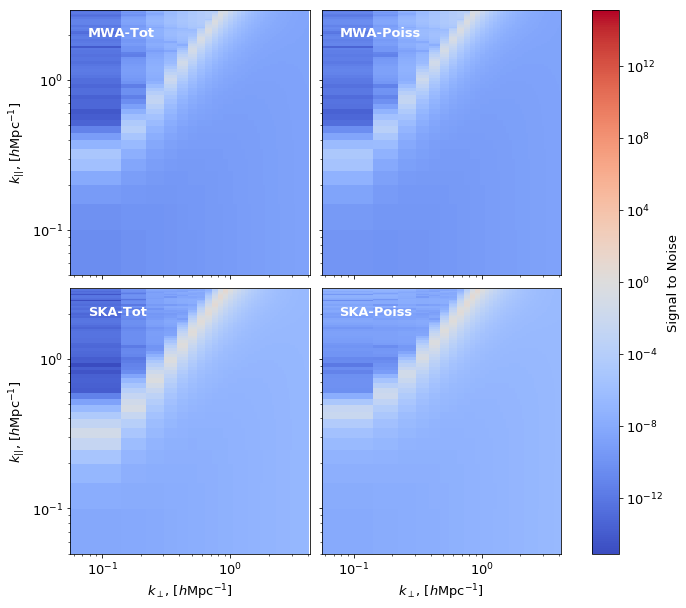

In [88]:
fig,ax = plot_sig_to_noise_compare([[np.abs(total_power['mwa'])/fid_pc['mwa_t'],np.abs(total_power['ska'])/fid_pc['ska_t']],
                                    [np.abs(total_power['mwa'])/fid_pc['mwa_p'],np.abs(total_power['ska'])/fid_pc['ska_p']]],
                                   kperp,kpar,plt_labels=[["MWA-Tot", "SKA-Tot"],["MWA-Poiss","SKA-Poiss"]])

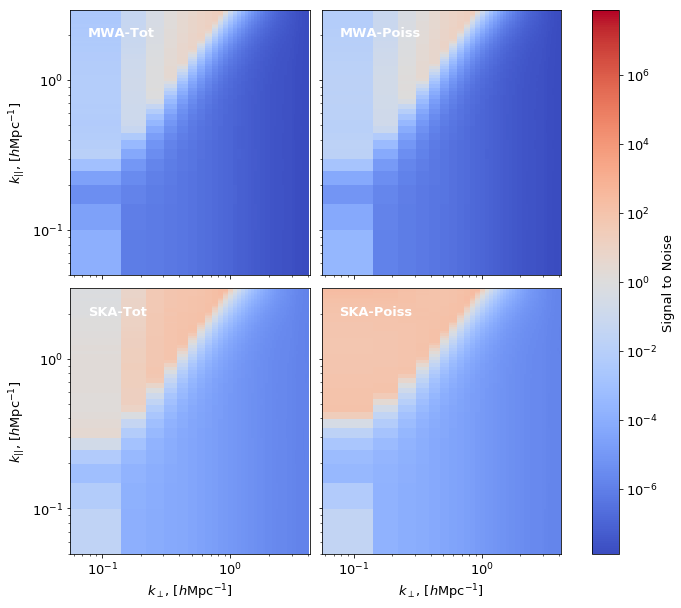

In [235]:
fig,ax = plot_sig_to_noise_compare([[pk_2d.T/np.sqrt(fid_pc['mwa_t']),pk_2d.T/np.sqrt(fid_pc['ska_t'])],
                                    [pk_2d.T/np.sqrt(fid_pc['mwa_p']),pk_2d.T/np.sqrt(fid_pc['ska_p'])]],
                                   kperp,kpar,plt_labels=[["MWA-Tot", "SKA-Tot"],["MWA-Poiss","SKA-Poiss"]])

if figdir:
    for suffix in ['pdf','png']:
        fig.savefig(join(figdir,"signal_to_noise_fiducial.%s"%suffix))

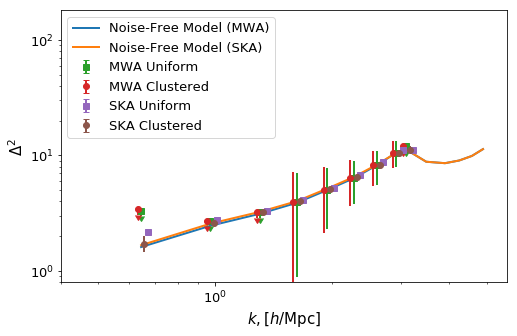

In [236]:
#fig,ax = make_1d_plot_ax(kav_1d,pk_1d/(kav_1d**3/(2*np.pi**2)), fid_k_1d, fid_signal, fid_variance)
fig,ax = make_1d_plot_ax(total_power, fid_k_1d, fid_signal, fid_variance)

#### Low kappa (my actual fiducial)

In [237]:
lk_pc, lk_models, lk_k_1d, lk_signal, lk_variance, lk_total_power, lk_ks = make_models(1e-4,1.95,0.05,1.5,simf0,sim_u)

#### low smin

In [238]:
ls_pc, ls_models, ls_k_1d, ls_signal, ls_variance, ls_total_power, ls_ks = make_models(1e-6,1.95,0.05,1.5,simf0,sim_u)

#### Higher kappa

In [239]:
hk_pc, hk_models, hk_k_1d, hk_signal, hk_variance, hk_total_power, hk_ks = make_models(1e-4,1.95,0.05,2.5,simf0,sim_u)

#### Higher beta1

In [240]:
hb_pc, hb_models, hb_k_1d, hb_signal, hb_variance, hb_total_power, hb_ks = make_models(1e-4,2.2,0.05,1.5,simf0,sim_u)

#### Higher u0

In [241]:
hu_pc, hu_models, hu_k_1d, hu_signal, hu_variance, hu_total_power, hu_ks = make_models(1e-4,2.2,0.1,1.5,simf0,sim_u)

#### Plot all 1D plots together

In [221]:
def make_1d_plots(total_power, k_1d, signal, variance, labels):
    fig, ax = plt.subplots(2,3, sharex=True, sharey=True, gridspec_kw={"hspace":0, 'wspace':0}, 
                           figsize=(12,7),subplot_kw={"ylim":(0.8,200)})
    
    print ax.shape, len(signal)
    for i in range(3):
        for j in range(2):
            if i==2 and j==0:
                ax[j,i].axis("off")
            else:
                #print total_power[i][j]
                fig, ax[j,i] = make_1d_plot_ax(total_power[i][j], k_1d[i][j], signal[i][j], variance[i][j],fig=fig,ax=ax[j,i],plt_labels=False)
                ax[j,i].text(1.,100,labels[i][j], fontsize=15, fontweight='bold')

                if i==0:
                    ax[j,i].set_ylabel("$\Delta^2$",fontsize=15)
                if j==1:
                    ax[j,i].set_xlabel("$k,\ \ [h/\mathrm{Mpc}]$",fontsize=15)
                
    ax[1,0].legend(bbox_to_anchor=(0.895, 0.85),
                   bbox_transform=plt.gcf().transFigure)
    return fig, ax
            

(2, 3) 3


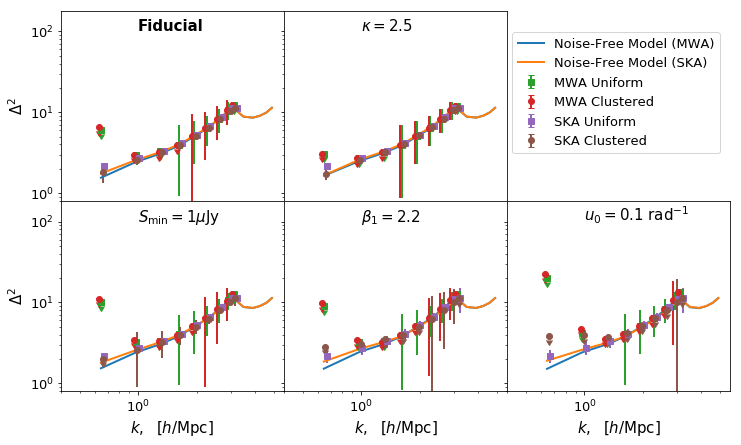

In [242]:
make_1d_plots([[lk_total_power, ls_total_power], [hk_total_power, hb_total_power],[None, hu_total_power]], [[lk_k_1d, ls_k_1d],[hk_k_1d,hb_k_1d],[None,hu_k_1d]], [[lk_signal, ls_signal],[hk_signal,hb_signal],[None,hu_signal]],
              [[lk_variance, ls_variance],[hk_variance,hb_variance],[None,hu_variance]], labels=[["Fiducial", r"$S_\mathrm{min} = 1\mu \mathrm{Jy}$"],[r"$\kappa=2.5$", r"$\beta_1 = 2.2$"],[None,r"$u_0 = 0.1 \ \mathrm{rad}^{-1}$"]])

if figdir:
    plt.savefig(join(figdir,"final_1d_plots_panels.pdf"))

In [210]:
np.random.multivariate_normal?

In [211]:
np.diag?

In [220]:
from scipy.linalg import dft
N = 100
power = np.zeros((100,N))
cov = np.diag(np.linspace(0,20,N)**2)
for i in range(100):
    x = np.random.multivariate_normal(mean=100000.*np.ones(N),
                                      cov=cov)
    F = dft(N, "sqrtn")
    power[i] = np.abs(F.dot(x))**2
    
print np.mean(power, axis=0)
print np.mean(power[1:,1:])
print np.real(np.diag(np.conjugate(F.T).dot(cov).dot(F)))
print np.real(np.diag(np.sqrt(np.conjugate(F.T).dot(cov).dot(cov).dot(F))))

[  9.99999652e+11   1.38246011e+02   1.36251760e+02   1.41445836e+02
   1.41068613e+02   1.15834530e+02   1.01660614e+02   9.96002505e+01
   1.18090552e+02   1.34239980e+02   1.40438589e+02   1.20123837e+02
   1.46683304e+02   1.29283027e+02   1.31241313e+02   1.36849152e+02
   1.20723012e+02   1.42401933e+02   1.38474491e+02   1.39734244e+02
   1.69305992e+02   1.50308759e+02   1.29462302e+02   1.33606575e+02
   1.43580300e+02   1.15965812e+02   1.09609522e+02   1.37919298e+02
   1.46352884e+02   1.66885628e+02   1.42368559e+02   1.20065551e+02
   1.10885710e+02   1.49416771e+02   1.48611995e+02   1.43145039e+02
   1.34347155e+02   1.28013233e+02   1.30329449e+02   1.25933657e+02
   1.22070812e+02   1.25500477e+02   1.32226524e+02   1.19329730e+02
   1.29807194e+02   1.26090336e+02   1.56217299e+02   1.24284101e+02
   1.27065258e+02   1.50229480e+02   1.52500378e+02   1.50229480e+02
   1.27065258e+02   1.24284101e+02   1.56217299e+02   1.26090336e+02
   1.29807194e+02   1.19329730e+02

In [202]:
np.eye?